# Predicting County-Level Alzheimer's Mortality Rates

## Abstract:


### Background

An estimated 5.4 million people in the United States suffer from Alzheimer's disease. It's the 6th-leading cause of death in the US, higher than breast & prostate cancer combined. One interesting insight is the fact that Alzheimer's may be related to high levels of blood glucose, as is seen in diabetes. 

County-level diabetes rates can be predicted well using a Random Forest model, I wanted to see if Alzheimer's rates can also be predicted--and what factors the two diseases might have in common.

### Methods

Because health is affected by a wide range of variables, I sought out all publicly available county data on health, food access, socioeconomics, demographics, and employment. My research & predictions are centered around county-level data. 

### Models

I used Random Forest Regression models to predict:

* Age-adjusted Alzheimer's mortality
* Age-adjusted Diabetes mortality
* Adult Diabetes rates

I also used Lasso and Decision Tree regression to investigate relationships between variables.

### Findings

The incidence of Adult Diabetes in a given county is highly predictable, while age-adjusted Diabetes & Alzheimer's mortality rates are less so.

While Adult Diabetes and Diabetes mortality share several variables, Alzheimer's mortality predictors differ slightly. 

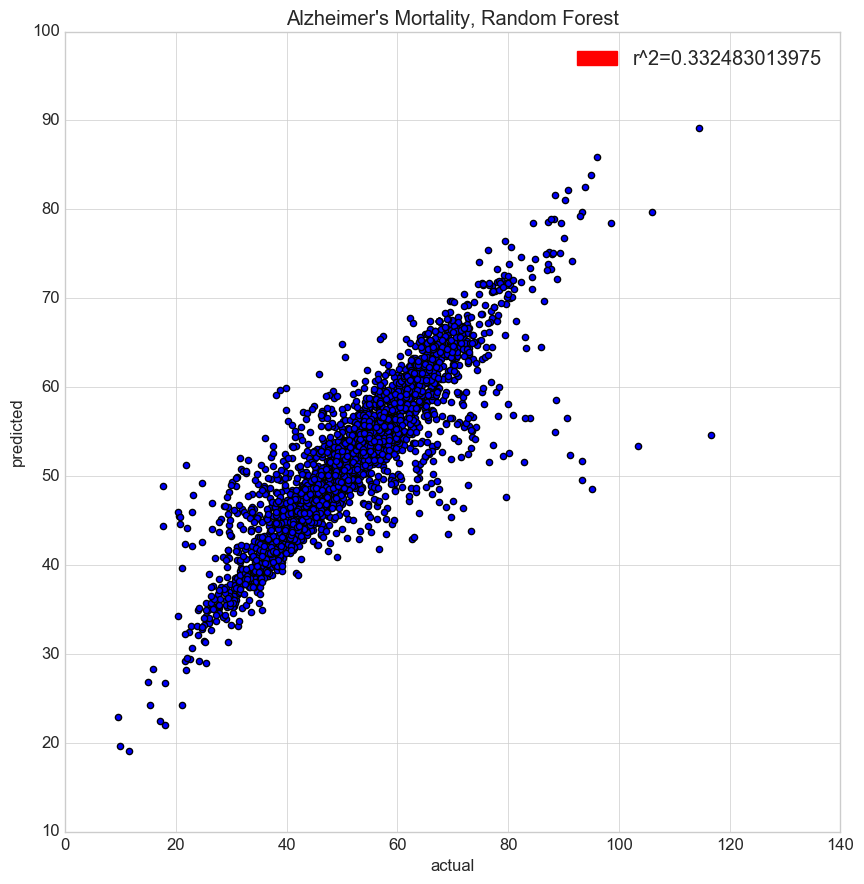

In [1]:
from IPython.display import Image
Image("/Users/deniseremhof/Desktop/Capstone/Images/rfr_alz_mort.png")

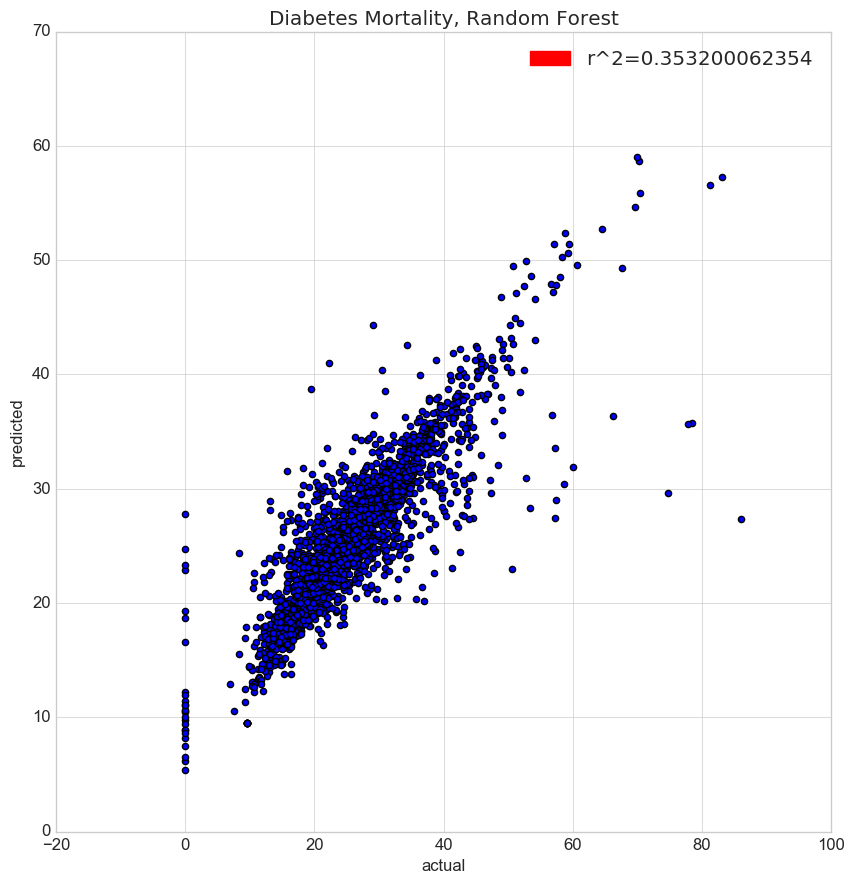

In [2]:
Image("/Users/deniseremhof/Desktop/Capstone/Images/dia_mort_rfr.png")

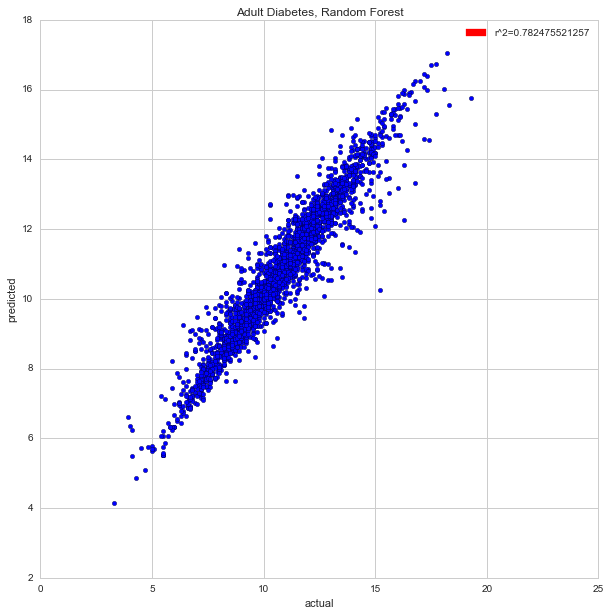

In [3]:
Image("/Users/deniseremhof/Desktop/Capstone/Images/dia_rfr.png")

### Important variables

The features in the Diabetes/Diabetes mortality rate models show clear similarities--it's easy to deduce feature relationships even with the black box nature of the models. Features that correlate to high Diabetes mortality rate and Adult Diabetes include:

* Poverty/Low Income
* Food Insecurity/Access
* Low education
* Usage of government food aid such as SNAP
* High overall mortality rate

Because the collinearity of Alzheimer's mortality-related features is tough to tease out on feature importance alone, I used Lasso and a single Decision Tree to dig into feature relationships for Alzheimer's mortality rate. I found that 
the following relate positively to  Alzheimer's mortality rates:

* Per capita and household income income (especially when in larger metro areas)
* Obesity (especially when in larger metro areas)
* Education levels (some college +)
* Overall age-adjusted mortality rate
* County classification as a retirement destination. This measure is particularly interesting because the Alzheimer's mortality rates have been age-adjusted. This means that there's something important about retirement communities OTHER than advanced age of county residence.
* High fast food consumption
* Low unemployment
* High population % who are 65+ (this is especially interesting because the Alzheimer's mortality rate is age-adjusted, meaning there's something intrinsic to these counties OTHER than having a high percentage of people who are likely to die from Alzheimer's.
* Household food insecurity (lack of access to grocery stores, where convenience stores might instead be fulfilling a county's nutritional needs). This is in line with what we'd find in a larger, high-density metro area.
* High % of veterans. Veterans tend to be older (the average age is 58), so this is in line with our findings about older populations.

### Conclusions & Further Research

The incidence of Adult Diabetes in a given county is highly predictable, while age-adjusted Diabetes & Alzheimer's mortality rates are less so.

While Adult Diabetes and Diabetes mortality share several variables, Alzheimer's mortality predictors differ greatly from them. Any medical relationship between Alzheimer's and Diabetes doesn't manifest itself strongly in the given predictors. 

I hypothesize that as higher-income, higher-education people live longer and move to retirement communities, the likelihood of contracting Alzheimer's increases.

One aspect I'm curious about is the paradoxical nature of both lack of food access/high fast food consumption, combined with high income. These factors may not manifest themselves in the same counties; it's possible that these two groups exist in different regions. The map below suggests that Alzheimer's mortality rates are particularly high in the southern states--where you'd typically find "food deserts"--but also in wealthier, denser areas on the coasts. 

It's possible that the publicly available county-level predictors are insufficient for the purpose of Alzheimer's incidence. Future Alzheimer's research should consider other factors not included in this report. For example, county-level data on blood glucose levels or sugar consumption might provide better links between Diabetes & Alzheimer's. 

It's a shame that county-level Alzheimer's rates aren't available, as they'd likely provide more clarity than Alzheimer's rates alone. These Alzheimer's county rates have been imputed by other studies, but the data is unavailable to the public. 


#### Import data, packages, libraies, and define target

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
plt.style.use('seaborn-whitegrid')
%matplotlib inline

alz = pd.read_csv('/Users/deniseremhof/Desktop/alz_oct_11.csv')
alz = alz.drop('Unnamed: 0', axis=1)

In [5]:
from sklearn.ensemble import RandomForestRegressor
## Define y
y = alz['death_rate_alz']

## Define X
columns_ = alz.columns.tolist()
exclude_cols = ['death_rate_alz','county_name','FIPS','State']
X = alz[[i for i in columns_ if i not in exclude_cols]]

## Print shapes of y and X
print y.shape, X.shape

(2701,) (2701, 139)


### Baselines/EDA

### Data Includes:

#### Socioeconomic Factors
    a) Access/availability of grocery stores, convenience stores, superstores
    b) Goverment food assistance such as SNAP/WIC
    c) Education levels
    d) Unemployment
    e) Poverty/child poverty
    f) Income
    

#### Health factors
    a) Age-adjusted overall mortality rate
    b) Age-adjusted Alzheimer's mortality rate
    c) Adult & childhood obesity rates
    d) Adult diabetes rates
    e) Inactivity rates
    f) Obesity Rates
    
#### Demographics
    a) Ethnic background
    b) Veterans
    c) English-speaking households
       
#### County Classifications
    a) Metro vs. NonMetro
    b) Economic dependencies (farming, mining, government, etc.)
    c) Rural/urban continuum code
    d) State


#### d3  Map: Alzheimer's Mortality Rates by County

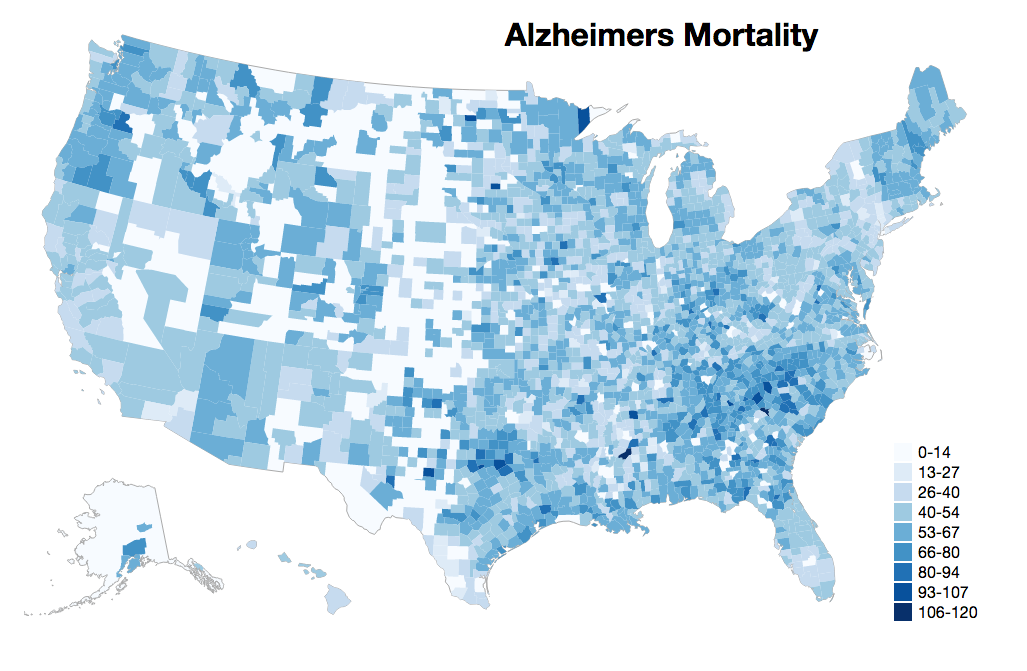

In [6]:
Image("/Users/deniseremhof/Desktop/Capstone/Images/d3_alz_mort.png")

####  Interactions of key features

This heatmap shows correlations between features in this dataset. Most notably, it calls out the relationships between income, poverty level, mortality rate, and education.

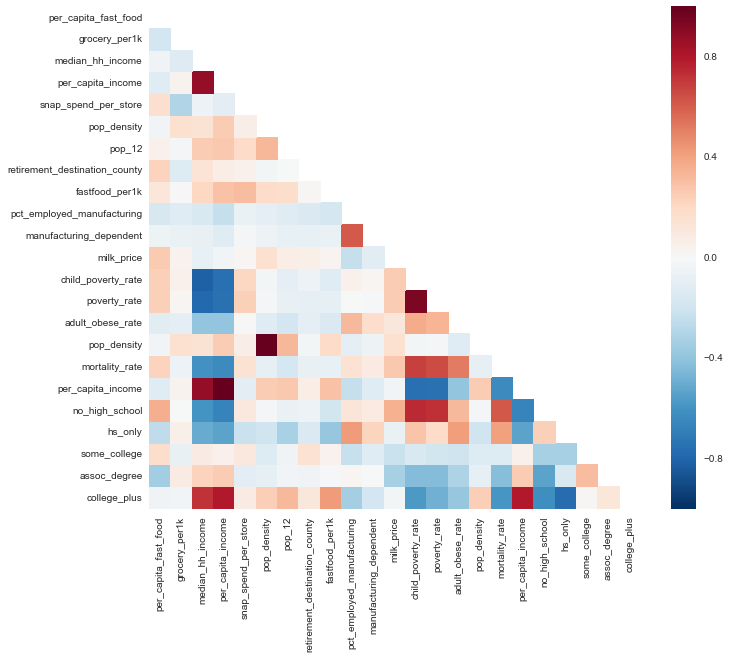

In [7]:
key_features= alz[['per_capita_fast_food','grocery_per1k', 'median_hh_income', 'per_capita_income', 'snap_spend_per_store', 
            'pop_density', 'pop_12', 'retirement_destination_county','fastfood_per1k',
           'pct_employed_manufacturing','manufacturing_dependent','milk_price','child_poverty_rate','poverty_rate',
           'adult_obese_rate', 'pop_density','mortality_rate','per_capita_income', 'no_high_school', 'hs_only', 
            'some_college', 'assoc_degree',
       'college_plus']]

sns.set(style="white")

corr = key_features.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, ax=ax)

plt.show()

#### The following 2 graphs show baseline distributions for various mortality rates, as well as incidence of Adult Diabetes.

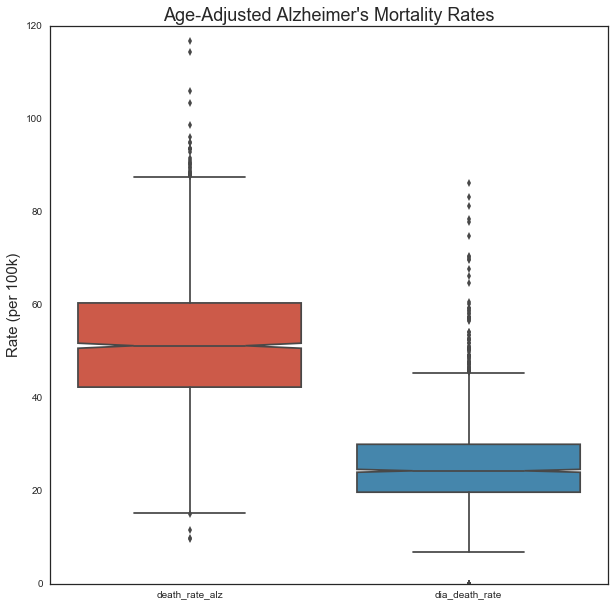

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.style.use('ggplot')

ax = sns.boxplot(data=alz[['death_rate_alz','dia_death_rate']], ax=ax, notch=True)
ax.set_title("Age-Adjusted Alzheimer's Mortality Rates", fontsize=18)
plt.ylabel('Rate (per 100k)',fontsize=15)

plt.show()

In [9]:
alz.death_rate_alz.describe()

count    2701.000000
mean       51.673380
std        13.492806
min         9.600000
25%        42.300000
50%        51.200000
75%        60.400000
max       116.700000
Name: death_rate_alz, dtype: float64

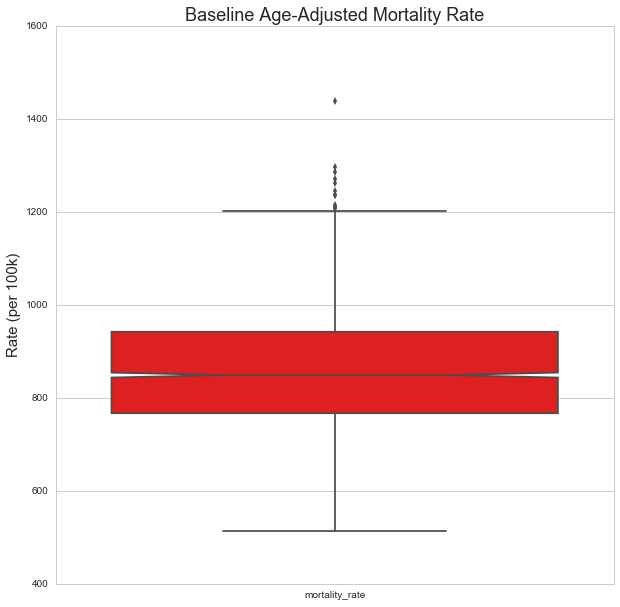

In [10]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))
ax = fig.gca()

ax = sns.boxplot(data=alz[['mortality_rate']], ax=ax, notch=True,color='r')
ax.set_title("Baseline Age-Adjusted Mortality Rate", fontsize=18)
plt.ylabel('Rate (per 100k)',fontsize=15)

plt.show()

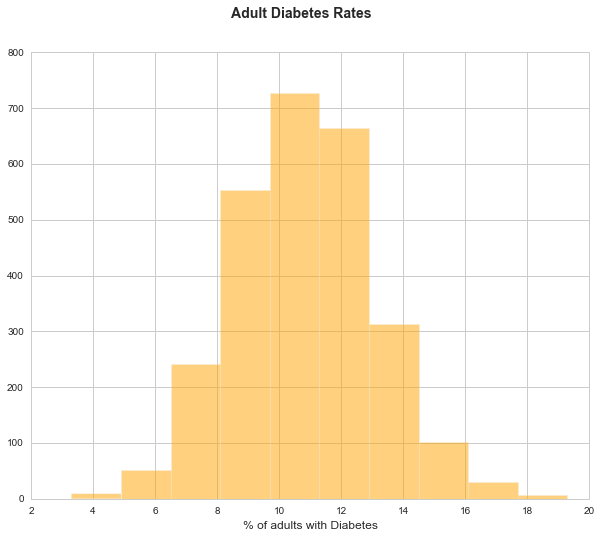

In [11]:
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111)
fig.suptitle("Adult Diabetes Rates", fontsize=14, fontweight='bold')
plt.hist(X.adult_diabetes_rate,alpha=0.5, label='Diabetes', color = 'orange')
ax.set_xlabel("% of adults with Diabetes")

plt.show()

### Which variables correlate with our target variables?

In [12]:
new_df = alz.corr()

In [13]:
new_df['death_rate_alz'].sort_values(ascending=False)

death_rate_alz                    1.000000
per_capita_fast_food              0.217514
retirement_destination_county     0.205488
metro_250k_1mil                   0.167313
college_plus                      0.160124
GA                                0.159321
median_hh_income                  0.147439
metro_1mil_plus                   0.146636
fastfood_per1k                    0.143827
mortality_rate                    0.129525
SC                                0.126955
snap_spend_per_store              0.125418
pct_employed_services             0.122292
NC                                0.115859
some_college                      0.103518
pct_under18                       0.097982
per_capita_income                 0.095208
per_capita_full_service           0.087347
AL                                0.077637
TN                                0.073869
avg_hh_size                       0.069546
TX                                0.065470
VA                                0.057704
rec_facil_p

In [14]:
new_df['mortality_rate'].sort_values(ascending=False)

mortality_rate                    1.000000
adult_diabetes_rate               0.716438
inactivity_rate                   0.704801
child_poverty_rate                0.683710
snap_per_capita                   0.678741
poverty_rate                      0.652946
no_high_school                    0.618644
snap_stores_per1k                 0.594816
adult_obese_rate                  0.521680
dia_death_rate                    0.513483
low_employment_county             0.508699
unemployment                      0.495907
households_lo_car_store_pct       0.487380
per_child_poverty_county_class    0.481125
household_foodinsec               0.449485
pct_black                         0.438001
hs_only                           0.410732
per_poverty_county_class          0.408701
convenience_per1k                 0.375695
milk_soda_price                   0.346670
low_education_county              0.342150
child_foodinsec                   0.325897
milk_price                        0.270568
food_tax   

In [15]:
new_df['adult_diabetes_rate'].sort_values(ascending=False)

adult_diabetes_rate               1.000000
inactivity_rate                   0.734878
mortality_rate                    0.716438
child_poverty_rate                0.641488
adult_obese_rate                  0.576772
snap_stores_per1k                 0.574848
households_lo_car_store_pct       0.564157
snap_per_capita                   0.562827
poverty_rate                      0.554420
no_high_school                    0.544639
low_employment_county             0.497207
unemployment                      0.493359
hs_only                           0.492080
pct_black                         0.490799
per_child_poverty_county_class    0.458578
milk_soda_price                   0.404693
household_foodinsec               0.400150
convenience_per1k                 0.397822
dia_death_rate                    0.383439
per_poverty_county_class          0.376526
milk_price                        0.307030
pct_hh_65plus_livealone           0.299067
food_tax                          0.281449
chips_tax_s

### Prepare for Random Forest Regression.

I selected a Random Forest model because:

* I have a lot of variables, both categorical and continuous
* I'm seeking high accuracy, and I'm sure there are relationships between variables that I wouldn't be able to come up with on my own

#### Train/test split, gridsearch optimal parameters, and fit the model

In [16]:
## Train test split 70/30
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Print shapes of X(s) and y(s)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(1890, 139) (1890,)
(811, 139) (811,)


In [17]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor( )

params = {'max_depth':[2,3,4,5,6,None], 
          'max_features':['sqrt','log2'],
          'min_samples_split':[2,4,8,16,32,64,128],
          'n_estimators': [500]
         }

estimator_rfr = GridSearchCV(forest, params, n_jobs=1, cv=5, verbose=2)

In [18]:
model = estimator_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 -   1.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 -   1.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 -   1.3s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 -   1.4s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=500, max_depth=2 -   1.4s
[CV] max_features=sqrt, min_samples_split=4, n_estimators=500, max_depth=2 
[CV]  max_features=sqrt, min_samples_split=4, n_estimator

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:   52.2s


[CV]  max_features=log2, min_samples_split=4, n_estimators=500, max_depth=2 -   1.4s
[CV] max_features=log2, min_samples_split=4, n_estimators=500, max_depth=2 
[CV]  max_features=log2, min_samples_split=4, n_estimators=500, max_depth=2 -   1.3s
[CV] max_features=log2, min_samples_split=4, n_estimators=500, max_depth=2 
[CV]  max_features=log2, min_samples_split=4, n_estimators=500, max_depth=2 -   1.3s
[CV] max_features=log2, min_samples_split=4, n_estimators=500, max_depth=2 
[CV]  max_features=log2, min_samples_split=4, n_estimators=500, max_depth=2 -   1.2s
[CV] max_features=log2, min_samples_split=4, n_estimators=500, max_depth=2 
[CV]  max_features=log2, min_samples_split=4, n_estimators=500, max_depth=2 -   1.2s
[CV] max_features=log2, min_samples_split=8, n_estimators=500, max_depth=2 
[CV]  max_features=log2, min_samples_split=8, n_estimators=500, max_depth=2 -   1.2s
[CV] max_features=log2, min_samples_split=8, n_estimators=500, max_depth=2 
[CV]  max_features=log2, min_sampl

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:  3.6min


[CV]  max_features=sqrt, min_samples_split=32, n_estimators=500, max_depth=4 -   1.6s
[CV] max_features=sqrt, min_samples_split=32, n_estimators=500, max_depth=4 
[CV]  max_features=sqrt, min_samples_split=32, n_estimators=500, max_depth=4 -   1.6s
[CV] max_features=sqrt, min_samples_split=32, n_estimators=500, max_depth=4 
[CV]  max_features=sqrt, min_samples_split=32, n_estimators=500, max_depth=4 -   1.8s
[CV] max_features=sqrt, min_samples_split=32, n_estimators=500, max_depth=4 
[CV]  max_features=sqrt, min_samples_split=32, n_estimators=500, max_depth=4 -   1.8s
[CV] max_features=sqrt, min_samples_split=64, n_estimators=500, max_depth=4 
[CV]  max_features=sqrt, min_samples_split=64, n_estimators=500, max_depth=4 -   1.6s
[CV] max_features=sqrt, min_samples_split=64, n_estimators=500, max_depth=4 
[CV]  max_features=sqrt, min_samples_split=64, n_estimators=500, max_depth=4 -   1.6s
[CV] max_features=sqrt, min_samples_split=64, n_estimators=500, max_depth=4 
[CV]  max_features=sqr

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:  9.3min


[CV]  max_features=sqrt, min_samples_split=8, n_estimators=500, max_depth=None -   2.7s
[CV] max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None 
[CV]  max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None -   2.5s
[CV] max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None 
[CV]  max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None -   2.8s
[CV] max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None 
[CV]  max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None -   2.7s
[CV] max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None 
[CV]  max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None -   2.6s
[CV] max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None 
[CV]  max_features=sqrt, min_samples_split=16, n_estimators=500, max_depth=None -   2.4s
[CV] max_features=sqrt, min_samples_split=32, n_estimators=500, max

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 11.3min finished


### Best parameters, estimators, and score

About this....

In [19]:
## Print best estimator, best parameters, and best score
rfr_best = estimator_rfr.best_estimator_
print "best estimator", rfr_best
print "\n==========\n"
print "best parameters", estimator_rfr.best_params_
print "\n==========\n"
print "best score", estimator_rfr.best_score_

best estimator RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


best parameters {'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 500, 'max_depth': None}


best score 0.304419788137


### Mean-squared error and R^2

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

y_train_pred = estimator_rfr.predict(X_train)
y_test_pred = estimator_rfr.predict(X_test)

print('MSE train: %.2f, test: %.2f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 21.84, test: 115.68
R^2 train: 0.88, test: 0.36


In [21]:
cols = X.columns

r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

/Users/deniseremhof/anaconda/envs/dsi/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


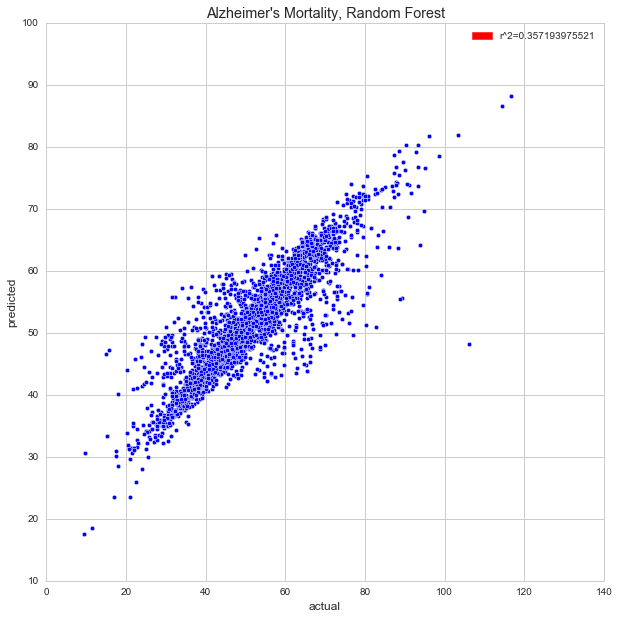

In [22]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,10))
plt.scatter(y, rfr_best.predict(X[cols]))
import matplotlib.patches as mpatches
plt.plot(legend="r^2=" + str(r2))
plt.legend(loc="lower right")
red_patch = mpatches.Patch(color='red', label="r^2=" + str(r2))
plt.legend(handles=[red_patch])
plt.title("Alzheimer's Mortality, Random Forest")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

### Plot Residuals to look for bias

In [23]:
yhat = rfr_best.predict(X)

resid = y - yhat

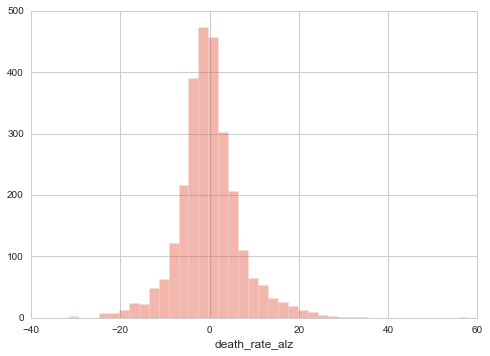

In [24]:
plt.style.use('seaborn-whitegrid')
sns.distplot(resid, bins=40, hist=True, kde=False)
plt.show()

#### Diabetes & Diabetes Mortality Rate

Random Forest code, models & plots for diabetes rates can be found here:

https://github.com/nikkikat3/DSI-SF-2-nikkikat3/commit/e004a2432eaa333fd3c651f4dff75981298bb7e3


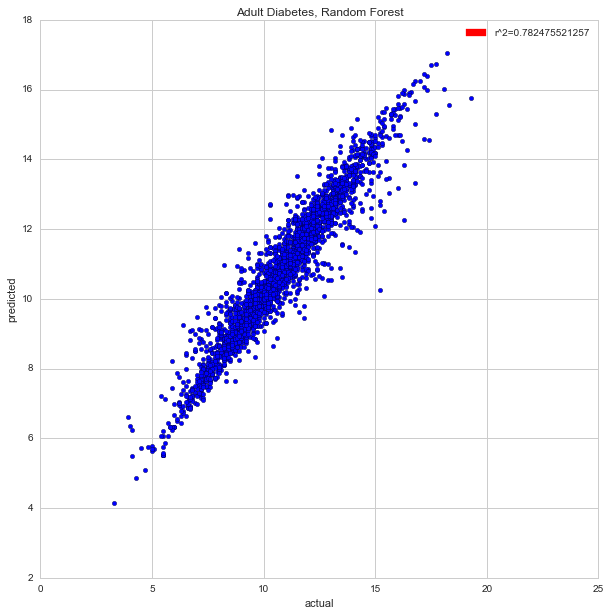

In [25]:
Image("/Users/deniseremhof/Desktop/Capstone/Images/dia_rfr.png")

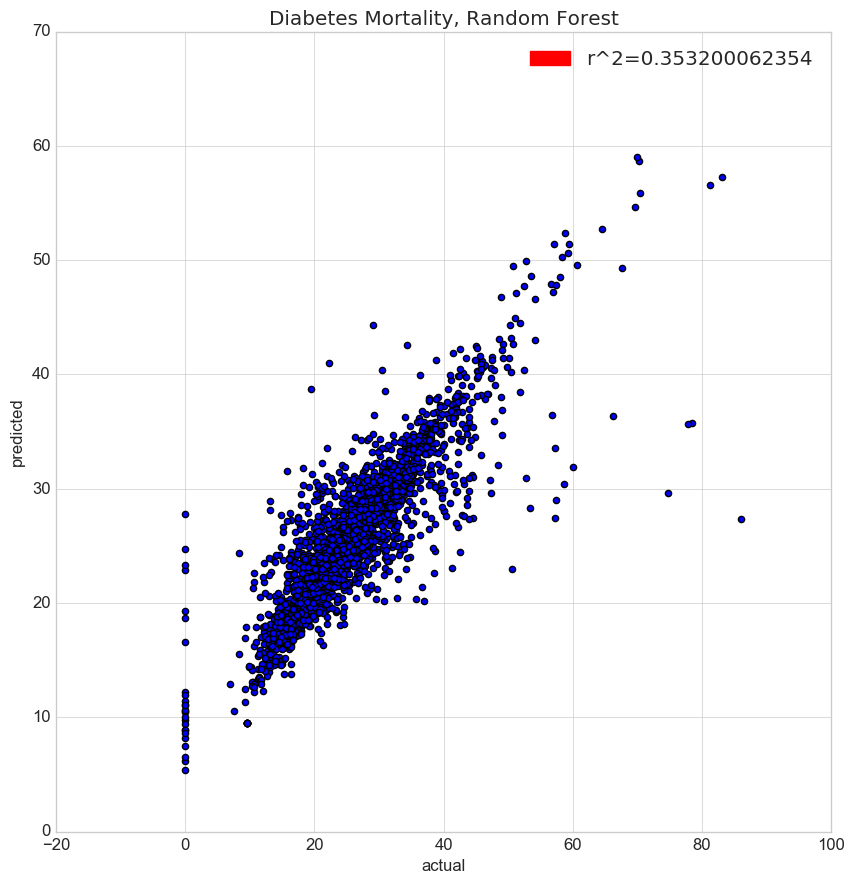

In [26]:
Image("/Users/deniseremhof/Desktop/Capstone/Images/dia_mort_rfr.png")

#### What can be said about these models?

The Adult Diabetes model accounts for the most variance, with an R^2 of .80 

The Alzheimer's and Diabetes mortality rate models perform similarly to one another at .35 and .37, respectively. 

### Random Forest Feature Importances

In [27]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':X.columns, 
                                   'importance':rfr_best.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.reset_index(inplace=True)

In [28]:
feature_importance.feature.dtypes
feature_importance['feature'] = map(lambda x: str(x), feature_importance.feature.values)
feature_importance['importance'] = map(lambda x: float(x), feature_importance.importance.values)

In [29]:
feature_importance[feature_importance['importance'] > 0]

,index,feature,importance
0,47,pop_density,0.036659
1,52,pct_employed_agriculture,0.028733
2,50,pct_hh_65plus_livealone,0.026259
3,1,pop_12,0.024306
4,69,mortality_rate,0.024254
5,25,per_capita_fast_food,0.021609
6,39,pct_over65,0.020979
7,27,grocery_per1k,0.020787
8,37,pct_native,0.019011
9,33,pct_white,0.018830


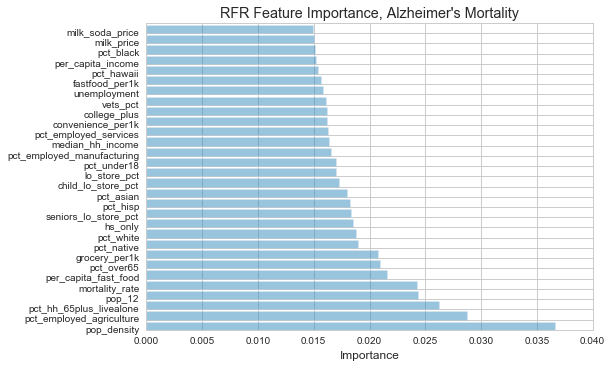

In [30]:
plt.style.use('seaborn-whitegrid')
# plt.rcdefaults()
# import numpy as np
# import matplotlib.pyplot as plt


# Example data
features = feature_importance.feature[:30]
y_pos = np.arange(len(features))
importance = feature_importance.importance[:30]
error = np.random.rand(len(features))

plt.barh(y_pos, importance, alpha=0.5)
plt.yticks(y_pos, features)
plt.xlabel('Importance')
plt.title("RFR Feature Importance, Alzheimer's Mortality")

plt.show()

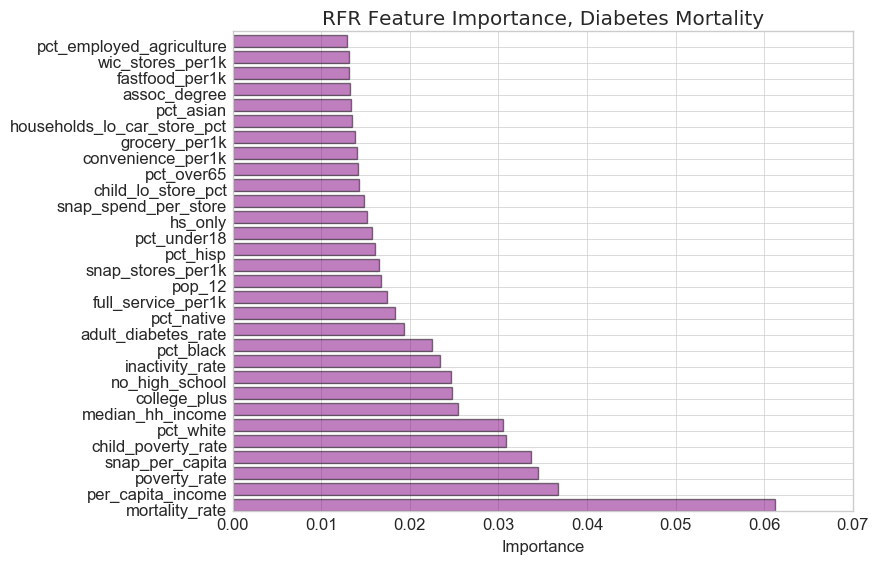

In [31]:
Image("/Users/deniseremhof/Desktop/Capstone/Images/rfr_fi_dia_mort.png")

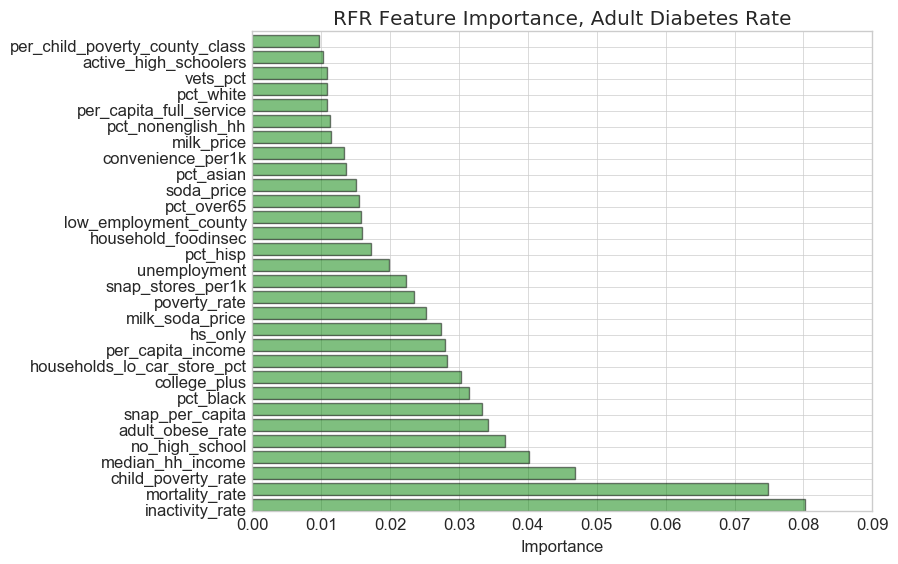

In [32]:
Image("/Users/deniseremhof/Desktop/Capstone/Images/rfr_dia_mort.png")

#### What do these feature importances tell us?

The features in the Diabetes/Diabetes mortality rate models show clear similarities--it's easy to deduce feature relationships even with the black box nature of the models. Features that correlate to high Diabetes mortality rate and Adult Diabetes include:

* Poverty/Low Income
* Food Insecurity/Access
* Low education
* Usage of government food aid such as SNAP
* High overall mortality rate

The features in the Alzheimer's mortality rate model are hard to decipher. They include:
* college education
* mortality rate
* SNAP benefits (like the other models)
* population density, 
* primary industry in that county (manufacturing)
* race (white, Native, Asian). 

Because the collinearity of these features is tough to tease out on feature importance alone, I used Lasso and a single Decision Tree to dig into feature relationships for Alzheimer's mortality rate.

### Teasing out feature interactions w/ a single Decision Tree

The model performed ok, but the feature importances don't make the model's interactions any clearer. Let's try a Decision Tree to see variable coefficients & cancel out noise variables.

In [33]:
from sklearn.grid_search import GridSearchCV

tree = DecisionTreeRegressor( )

params = {'max_depth':[2,3,4,5,6,None], 
          'max_features':['sqrt','log2'],
          'min_samples_split':[2,4,8,16,32,64,128]
         }

estimator_dtr = GridSearchCV(tree, params, n_jobs=1, cv=5, verbose=2)

In [34]:
model = estimator_dtr.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] max_features=sqrt, min_samples_split=2, max_depth=2 .............
[CV] .... max_features=sqrt, min_samples_split=2, max_depth=2 -   0.0s
[CV] max_features=sqrt, min_samples_split=2, max_depth=2 .............
[CV] .... max_features=sqrt, min_samples_split=2, max_depth=2 -   0.1s
[CV] max_features=sqrt, min_samples_split=2, max_depth=2 .............
[CV] .... max_features=sqrt, min_samples_split=2, max_depth=2 -   0.0s
[CV] max_features=sqrt, min_samples_split=2, max_depth=2 .............
[CV] .... max_features=sqrt, min_samples_split=2, max_depth=2 -   0.0s
[CV] max_features=sqrt, min_samples_split=2, max_depth=2 .............
[CV] .... max_features=sqrt, min_samples_split=2, max_depth=2 -   0.0s
[CV] max_features=sqrt, min_samples_split=4, max_depth=2 .............
[CV] .... max_features=sqrt, min_samples_split=4, max_depth=2 -   0.0s
[CV] max_features=sqrt, min_samples_split=4, max_depth=2 .............
[CV] .... max_f

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.3s


[CV] ... max_features=log2, min_samples_split=16, max_depth=2 -   0.0s
[CV] max_features=log2, min_samples_split=32, max_depth=2 ............
[CV] ... max_features=log2, min_samples_split=32, max_depth=2 -   0.0s
[CV] max_features=log2, min_samples_split=32, max_depth=2 ............
[CV] ... max_features=log2, min_samples_split=32, max_depth=2 -   0.0s
[CV] max_features=log2, min_samples_split=32, max_depth=2 ............
[CV] ... max_features=log2, min_samples_split=32, max_depth=2 -   0.0s
[CV] max_features=log2, min_samples_split=32, max_depth=2 ............
[CV] ... max_features=log2, min_samples_split=32, max_depth=2 -   0.0s
[CV] max_features=log2, min_samples_split=32, max_depth=2 ............
[CV] ... max_features=log2, min_samples_split=32, max_depth=2 -   0.0s
[CV] max_features=log2, min_samples_split=64, max_depth=2 ............
[CV] ... max_features=log2, min_samples_split=64, max_depth=2 -   0.0s
[CV] max_features=log2, min_samples_split=64, max_depth=2 ............
[CV] .

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:    1.0s


[CV] ... max_features=sqrt, min_samples_split=32, max_depth=4 -   0.0s
[CV] max_features=sqrt, min_samples_split=32, max_depth=4 ............
[CV] ... max_features=sqrt, min_samples_split=32, max_depth=4 -   0.0s
[CV] max_features=sqrt, min_samples_split=32, max_depth=4 ............
[CV] ... max_features=sqrt, min_samples_split=32, max_depth=4 -   0.0s
[CV] max_features=sqrt, min_samples_split=32, max_depth=4 ............
[CV] ... max_features=sqrt, min_samples_split=32, max_depth=4 -   0.0s
[CV] max_features=sqrt, min_samples_split=64, max_depth=4 ............
[CV] ... max_features=sqrt, min_samples_split=64, max_depth=4 -   0.0s
[CV] max_features=sqrt, min_samples_split=64, max_depth=4 ............
[CV] ... max_features=sqrt, min_samples_split=64, max_depth=4 -   0.0s
[CV] max_features=sqrt, min_samples_split=64, max_depth=4 ............
[CV] ... max_features=sqrt, min_samples_split=64, max_depth=4 -   0.0s
[CV] max_features=sqrt, min_samples_split=64, max_depth=4 ............
[CV] .

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:    2.5s


[CV] . max_features=sqrt, min_samples_split=8, max_depth=None -   0.0s
[CV] max_features=sqrt, min_samples_split=16, max_depth=None .........
[CV]  max_features=sqrt, min_samples_split=16, max_depth=None -   0.0s
[CV] max_features=sqrt, min_samples_split=16, max_depth=None .........
[CV]  max_features=sqrt, min_samples_split=16, max_depth=None -   0.0s
[CV] max_features=sqrt, min_samples_split=16, max_depth=None .........
[CV]  max_features=sqrt, min_samples_split=16, max_depth=None -   0.0s
[CV] max_features=sqrt, min_samples_split=16, max_depth=None .........
[CV]  max_features=sqrt, min_samples_split=16, max_depth=None -   0.0s
[CV] max_features=sqrt, min_samples_split=16, max_depth=None .........
[CV]  max_features=sqrt, min_samples_split=16, max_depth=None -   0.0s
[CV] max_features=sqrt, min_samples_split=32, max_depth=None .........
[CV]  max_features=sqrt, min_samples_split=32, max_depth=None -   0.0s
[CV] max_features=sqrt, min_samples_split=32, max_depth=None .........
[CV]  

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    3.0s finished


In [61]:
## Print best estimator, best parameters, and best score
dtr_best = estimator_dtr.best_estimator_
print "best estimator", dtr_best
print "\n==========\n"
print "best parameters", estimator_dtr.best_params_
print "\n==========\n"
print "best score", estimator_dtr.best_score_

best estimator DecisionTreeRegressor(criterion='mse', max_depth=6, max_features='sqrt',
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=64,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


best parameters {'max_features': 'sqrt', 'min_samples_split': 64, 'max_depth': 6}


best score 0.124567971715


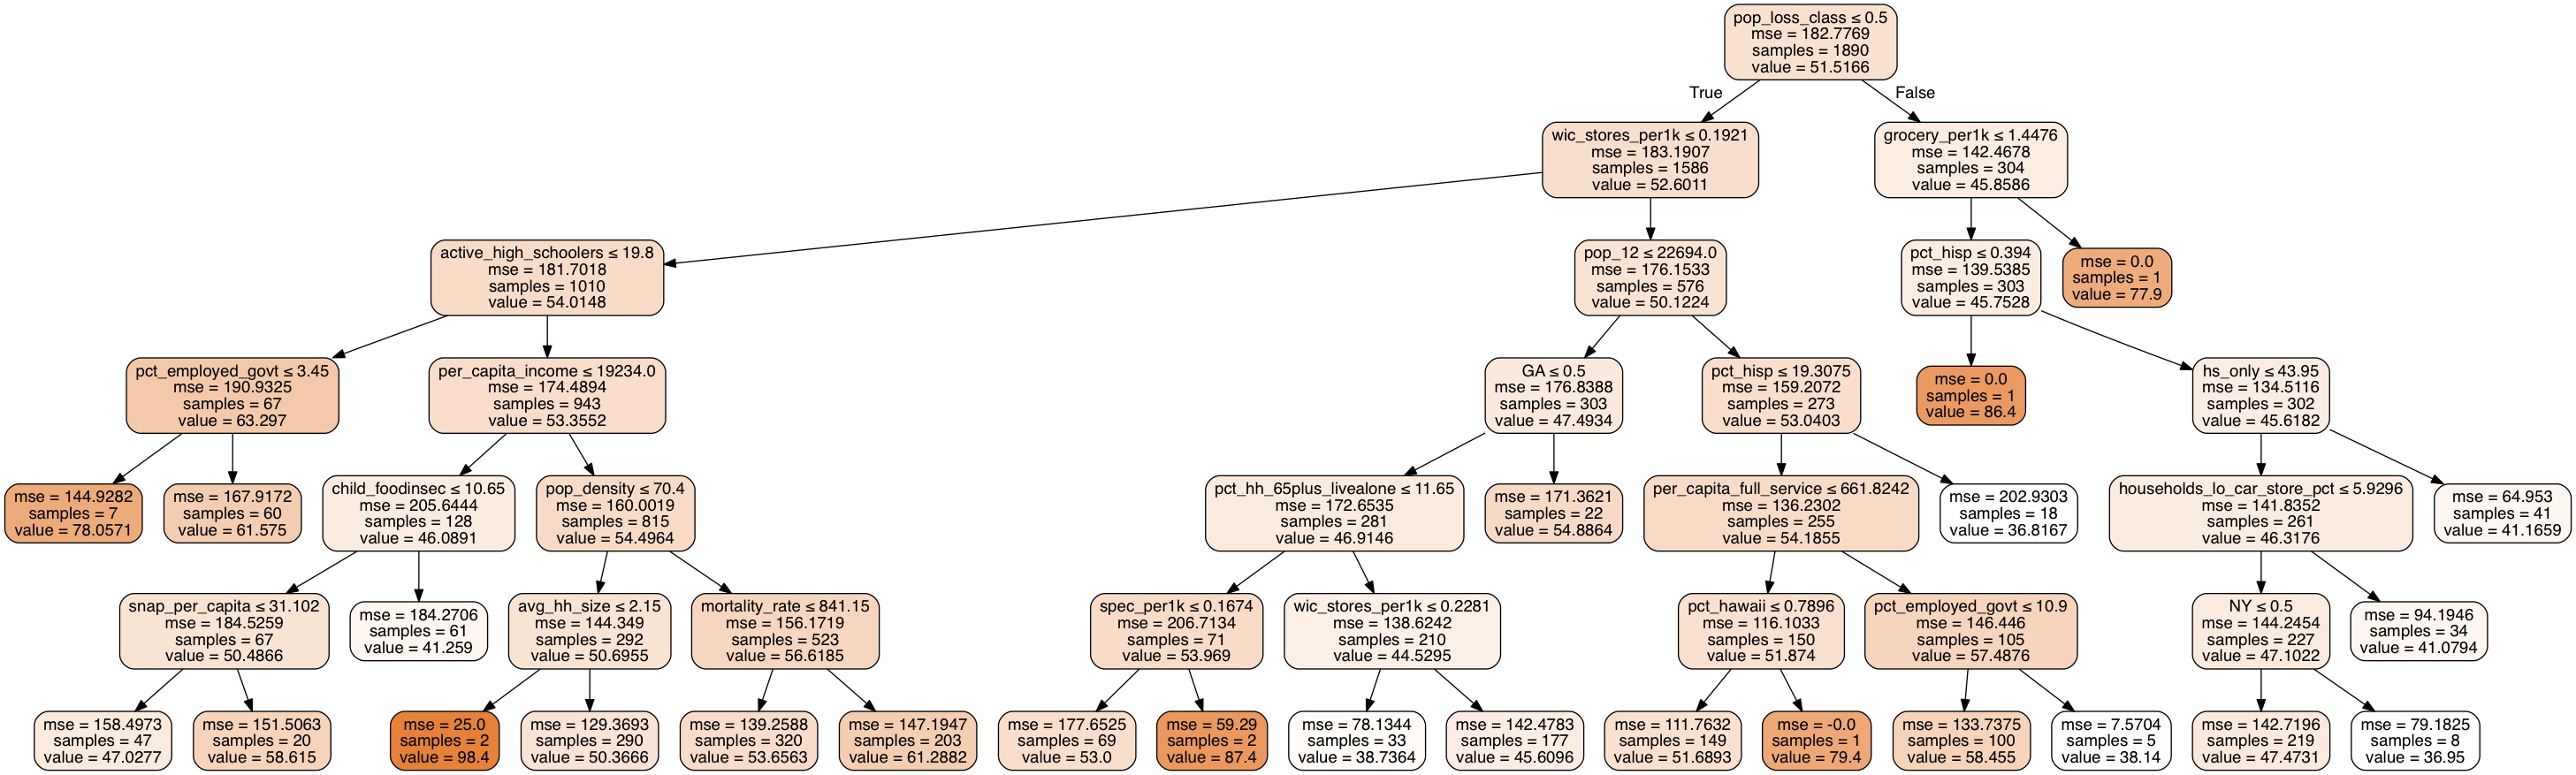

In [62]:
dot_data = StringIO()  

export_graphviz(dtr_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [37]:
alz.pop_density.describe()

count     2701.000000
mean       300.785450
std       1854.915418
min          0.800000
25%         25.900000
50%         56.200000
75%        141.100000
max      69468.400000
Name: pop_density, dtype: float64

#### What does the single Decision Tree tell us?

This model has fewer important variables, but we can see from the interactions that the following features have a positive impact on Alzheimer's mortality rates:

* Low population
* Low grocery store availability



In [63]:
fi = pd.DataFrame({
        'feature':X.columns,
        'importance':dtr_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(10)

,feature,importance
46,pop_loss_class,0.136101
68,per_capita_income,0.091764
69,mortality_rate,0.084900
32,wic_stores_per1k,0.080637
35,pct_hisp,0.078976
47,pop_density,0.077145
11,active_high_schoolers,0.072558
50,pct_hh_65plus_livealone,0.055483
49,avg_hh_size,0.053781
1,pop_12,0.051853


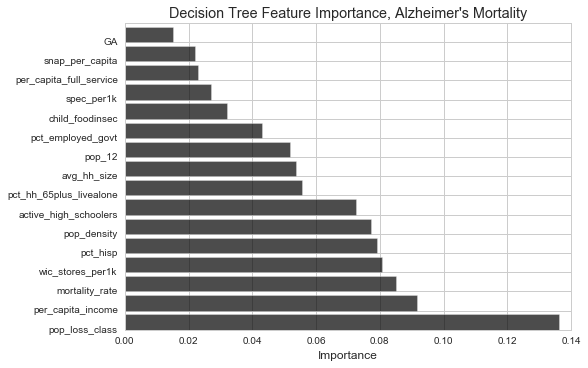

In [39]:
plt.style.use('seaborn-whitegrid')
# Example data
features = fi.feature[:16]
y_pos = np.arange(len(features))
importance = fi.importance[:16]

plt.barh(y_pos, importance, alpha=0.7, color = 'black')
plt.yticks(y_pos, features)
plt.xlabel('Importance')
plt.title("Decision Tree Feature Importance, Alzheimer's Mortality")

plt.show()

### LassoCV

Running Lasso to further clarify the impact of individual variables on the model via coefficients.

In [40]:
## Train test split 70/30
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

ss = StandardScaler()

# use the "fit_transform" function to normalize the X design matrix
Xn = ss.fit_transform(X)
test = pd.DataFrame(columns = X.columns, data =Xn )
Xn=test

In [41]:
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.3)

## Print shapes of X(s) and y(s)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

lassocv = LassoCV(n_alphas=200, verbose=1)
lassocv.fit(X_train, y_train)

(1890, 139) (1890,)
(811, 139) (811,)


................................................................................................................................................................................................../Users/deniseremhof/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
......................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=200, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=1)

In [42]:
lassocv.alpha_

0.14055670439276624

In [43]:
lassocv.score(X_test, y_test)

0.33077140719403042

In [44]:
alz.pop_density.describe()

count     2701.000000
mean       300.785450
std       1854.915418
min          0.800000
25%         25.900000
50%         56.200000
75%        141.100000
max      69468.400000
Name: pop_density, dtype: float64

In [45]:
lasso_coefs = pd.DataFrame({
        'predictor':X_train.columns,
        'coef':lassocv.coef_,
        'abscoef':np.abs(lassocv.coef_)
    })

lasso_coefs.sort_values('abscoef', ascending=False, inplace=True)
lasso_coefs.drop('abscoef', axis=1, inplace=True)
lasso_coefs

,coef,predictor
69,7.657902,mortality_rate
134,-1.952212,hs_only
33,1.919941,pct_white
110,1.615162,SC
80,1.560337,GA
104,-1.520131,NY
67,-1.393138,inactivity_rate
63,1.390955,retirement_destination_county
97,1.341570,NC
122,1.279088,metro_250k_1mil


In [46]:
# with interactions:
import patsy

X_formula = '~ (' +' + '.join(X_train.columns)+')**2 -1'
X_train_inter = patsy.dmatrix(X_formula, data=X_train, return_type='dataframe')

print X_train_inter.shape

(1890, 9730)


In [47]:
from sklearn.linear_model import LassoCV

lassocv = LassoCV(n_alphas=100, verbose=1)
lassocv.fit(X_train_inter, y_train)


............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.1min finished


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=1)

In [48]:
lasso_coefs = pd.DataFrame({
        'predictor':X_train_inter.columns,
        'coef':lassocv.coef_,
        'abscoef':np.abs(lassocv.coef_)
    })

lasso_coefs.sort_values('abscoef', ascending=False, inplace=True)
lasso_coefs.drop('abscoef', axis=1, inplace=True)
lasso_coefs.head(40)

,coef,predictor
69,4.545086,mortality_rate
134,-1.660725,hs_only
41,1.521253,median_hh_income
63,1.168844,retirement_destination_county
50,-0.919867,pct_hh_65plus_livealone
52,-0.772702,pct_employed_agriculture
122,0.692626,metro_250k_1mil
2428,0.683026,milk_soda_price:NC
46,-0.653832,pop_loss_class
51,-0.620332,unemployment


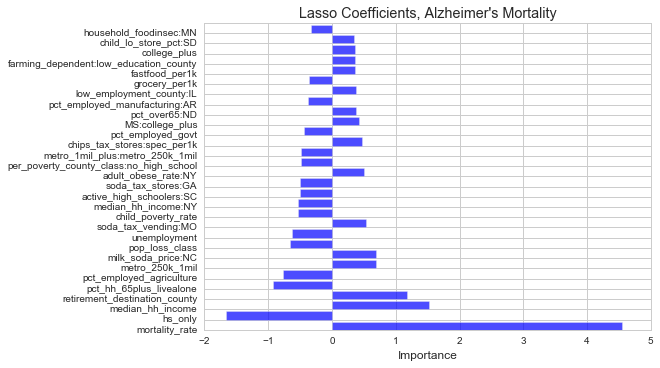

In [64]:
plt.style.use('seaborn-whitegrid')
# Example data
features = lasso_coefs.predictor[:30]
y_pos = np.arange(len(features))
importance = lasso_coefs.coef[:30]

plt.barh(y_pos, importance, alpha=0.7, color = 'blue')
plt.yticks(y_pos, features)
plt.xlabel('Importance')
plt.title("Lasso Coefficients, Alzheimer's Mortality")

plt.show()

#### Lasso tells us that the following relate to higher Alzheimer's mortality rates:

* Higher income (especially when in larger metro areas)
* Higher obesity (especially when in larger metro areas)
* Higher levels of education (some college +)
* High overall age-adjusted mortality rate
* Lower % seniors who live alone
* High fast food consumption

### Conclusions & Further Research

The incidence of Adult Diabetes in a given county is highly predictable, while age-adjusted Diabetes & Alzheimer's mortality rates are less so.

While Adult Diabetes and Diabetes mortality share several variables, Alzheimer's mortality predictors differ greatly from them. Any medical relationship between Alzheimer's and Diabetes doesn't manifest itself strongly in the given predictors. 

I hypothesize that as higher-income, higher-education people live longer and move to retirement communities, the likelihood of contracting Alzheimer's increases.

One aspect I'm curious about is the paradoxical nature of both lack of food access/high fast food consumption, combined with high income. These factors may not manifest themselves in the same counties; it's possible that these two groups exist in different regions. The map below suggests that Alzheimer's mortality rates are particularly high in the southern states--where you'd typically find "food deserts"--but also in wealthier, denser areas on the coasts. 

It's possible that the publicly available county-level predictors are insufficient for the purpose of Alzheimer's incidence. Future Alzheimer's research should consider other factors not included in this report. For example, county-level data on blood glucose levels or sugar consumption might provide better links between Diabetes & Alzheimer's. 

It's a shame that county-level Alzheimer's rates aren't available, as they'd likely provide more clarity than Alzheimer's rates alone. These Alzheimer's county rates have been imputed by other studies, but the data is unavailable to the public. 
